In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns

from math import log,exp,inf

from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq
from plotting_functions import *
import pickle
import copy

In [2]:
import ast
im_info = pd.read_csv('../data/precise_1.0/precise1_im_info.csv')

IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )
IM_genes.keys()

dict_keys(['GlpR', 'DhaR/Mlc', 'ArgR', 'NarL', 'MalT', 'OxyR', 'Crp-2', 'AtoC', 'PurR-1', 'CsqR', 'MetJ', 'PurR-2', 'Cbl+CysB', 'GlcC', 'Crp-1', 'YiaJ', 'GcvA', 'XylR', 'RpoH', 'GadEWX', 'PrpR', 'GadWX', 'CecR', 'ArcA-1', 'Fnr', 'CdaR', 'Pyruvate', 'SrlR+GutM', 'NagC/TyrR', 'CpxR', 'Lrp', 'Leu/Ile', 'Fur-1', 'Thiamine', 'CysB', 'FliA', 'PuuR', 'NikR', 'NtrC+RpoN', 'RcsAB', 'His-tRNA', 'Fur-2', 'Copper', 'AllR/AraC/FucR', 'Cra', 'ArcA-2', 'EvgA', 'Zinc', 'SoxS', 'Nac', 'Tryptophan', 'FadR/IclR', 'FlhDC', 'GntR/TyrR', 'RpoS', 'ExuR/FucR', 'FecI', 'RbsR'])

In [3]:
Both = { i for i in IM_genes['Crp-1'] if i in IM_genes['Crp-2'] }

In [4]:
Crp1_features = pd.read_csv('data/Crp1_features.csv',index_col=0)
Crp2_features = pd.read_csv('data/Crp2_features.csv', index_col=0)

Crp2_features_large = pd.read_csv('data/Crp2_features_large.csv', index_col=0)

In [5]:
fig, ax = plt.subplots()

ax.hist(Crp1_features[Crp1_features['ID'].isin(Both)]['Crp_TFToBox35'], color = 'red', alpha=1, bins=2)
ax.hist(Crp2_features[~Crp2_features['ID'].isin(Both)]['Crp_TFToBox35'], alpha=0.3, bins=10)
ax.hist(Crp1_features[~Crp1_features['ID'].isin(Both)]['Crp_TFToBox35'], color='green', alpha=0.3, bins=10)

ax.legend(['Both', 'Crp-2', 'Crp-1'])

ax.set_title('Crp to -35Box')

Text(0.5, 1.0, 'Crp to -35Box')

Text(0.5, 1.0, 'Crp to TSS')

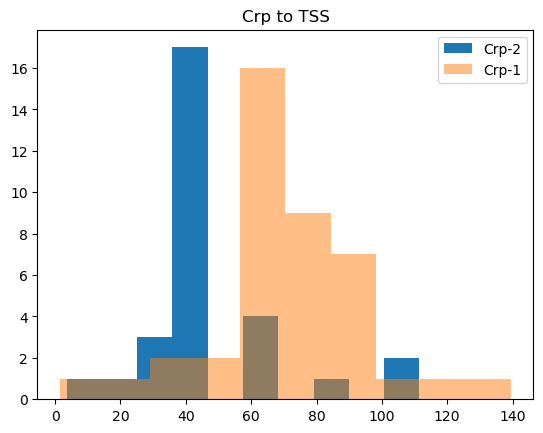

In [6]:
fig, ax = plt.subplots()
ax.hist(Crp2_features['Crp distToTSS'])
ax.hist(Crp1_features['Crp distToTSS'], alpha=0.5)

ax.legend(['Crp-2', 'Crp-1'])
ax.set_title('Crp to TSS')

In [7]:
Crp2_features[Crp2_features['Crp_TFToBox35']>10]['Crp score']

571      8.10
654      4.30
1321    10.60
1401    11.40
1402    11.40
1403    11.40
1882     5.15
Name: Crp score, dtype: float64

- come up with categorical variables for Crp-1 and Crp-2 (the high weighted ones in iModulon)
- looks into gene regulates by crp-1 and crp-2, where does Crp bind?
- log_odd scores vs location for each gene regulate by crp


- How much does distance affect the degree of regulation.

In [8]:
# categorical distance to box35
# 1: upstream, -1: downstrem, 0: overlap
# Crp length: 20
# Sigma length: 6-7


# define overlap: at least 3 bp overlap 

overlap_range = range(-24, -1)

Crp2_features['Crp_TFToBox35_cat'] = np.ones(Crp2_features.shape[0])*10

Crp2_features.loc[Crp2_features['Crp_TFToBox35'].isin(range(-26, 0)).index, 'Crp_TFToBox35_cat'] = 0
Crp2_features.loc[Crp2_features[Crp2_features['Crp_TFToBox35']>=-1].index, 'Crp_TFToBox35_cat'] = 1
Crp2_features.loc[Crp2_features[Crp2_features['Crp_TFToBox35']<-24].index, 'Crp_TFToBox35_cat'] = -1


Crp1_features['Crp_TFToBox35_cat'] = np.ones(Crp1_features.shape[0])*10

Crp1_features.loc[Crp1_features['Crp_TFToBox35'].isin(range(-26, 0)).index, 'Crp_TFToBox35_cat'] = 0
Crp1_features.loc[Crp1_features[Crp1_features['Crp_TFToBox35']>=-1].index, 'Crp_TFToBox35_cat'] = 1
Crp1_features.loc[Crp1_features[Crp1_features['Crp_TFToBox35']<-24].index, 'Crp_TFToBox35_cat'] = -1

In [9]:
Crp2_features[Crp2_features["Crp_TFToBox35_cat"]==1][['Crp_TFToBox35', 'strand', 'Sigma70_Prib_Start', 'Crp end']]

Crp_TFToBox35  strand  Sigma70_Prib_Start    Crp end
571            13.0     1.0                -6.0  1488141.0
654            64.0     1.0               -14.0  1669580.0
833             0.0    -1.0                -8.0  2177282.0
856             2.0    -1.0               -12.0  2240615.0
1321           40.0     1.0               -13.0  3532599.0
1401           12.0     1.0               -13.0  3772140.0
1402           12.0     1.0               -13.0  3772140.0
1403           12.0     1.0               -13.0  3772140.0
1690            2.0    -1.0               -12.0  4494484.0
1882           65.0     1.0               -14.5   755079.0
2113            4.5    -1.0                -9.0  2176885.0
2115            4.5    -1.0                -9.0  2176885.0
2116            4.5    -1.0                -9.0  2176885.0
2117            4.5    -1.0                -9.0  2176885.0
2119            0.5    -1.0                -9.0  2240032.0
2120            0.5    -1.0                -9.0  2240032.0

In [10]:
fig, ax = plt.subplots()

ax.hist(Crp2_features['Crp_TFToBox35_cat'])
ax.hist(Crp1_features['Crp_TFToBox35_cat'], alpha=0.5)

ax.legend(['Crp-2', 'Crp-1'])

In [32]:
Lrp_features_large = pd.read_csv('data/Lrp_features_large.csv', index_col=0)

In [33]:
Lrp_features_large

ID  strand  Sigma70_Prib_Start Lrp Matched Motif  Lrp score  \
94    b0077       1                 -17     GAATTTTATTCTG        9.1   
95    b0077       1                 -19     GAATTTTATTCTG        9.1   
96    b0077       1                 -16     GGATTTTATCGTT        5.9   
97    b0077       1                 -17     GGATTTTATCGTT        5.9   
98    b0078       1                 -17     GAATTTTATTCTG        9.1   
99    b0078       1                 -19     GAATTTTATTCTG        9.1   
100   b0078       1                 -16     GGATTTTATCGTT        5.9   
101   b0078       1                 -17     GGATTTTATCGTT        5.9   
1106  b1189       1                 -13     GAATTTTATGCTG        8.4   
1107  b1189       1                 -17     GAATTTTATGCTG        8.4   
1108  b1189       1                  -7     GATTATTATTCTT        7.9   
1109  b1190       1                 -13     GAATTTTATGCTG        8.4   
1110  b1190       1                 -17     GAATTTTATGCTG        8.4   
1111  b1190       1                  -7     GATTATTATTCTT        7.9   
1155  b1243       1                 -10     GATAGTAATACGT        1.5   
1156  b1244       1                 -10     GATAGTAATACGT        1.5   
1157  b1245       1                 -10     GATAGTAATACGT        1.5   
1158  b1246       1                 -10     GATAGTAATACGT        1.5   
1159  b1247       1                 -10     GATAGTAATACGT        1.5   
1453  b1634       1                 -18     AAATTTAACGCTG        4.1   
1601  b1798      -1                 -12     GAATTTTTCACTG        6.6   
1606  b1814       1                 -13     GAACAGTATTTTG        4.1   
2257  b2669      -1                 -14     TGAAATTATTCTG        5.2   
2258  b2669      -1                 -11     TGAAATTATTCTG        5.2   
2259  b2669      -1                  -9     TGAAATTATTCTG        5.2   
2260  b2670       1                 -11     AATTGATTTAATT        1.3   
2632  b3089       1                 -14     GCATTTTTCGCTT        5.6   
3084  b3454      -1                 -10     GCACTTTTTTCTG        7.3   
3085  b3454      -1                 -16     GCACTTTTTTCTG        7.3   
3086  b3455      -1                 -10     GCACTTTTTTCTG        7.3   
3087  b3455      -1                 -16     GCACTTTTTTCTG        7.3   
3088  b3456      -1                 -10     GCACTTTTTTCTG        7.3   
3089  b3456      -1                 -16     GCACTTTTTTCTG        7.3   
3090  b3457      -1                 -10     GCACTTTTTTCTG        7.3   
3091  b3457      -1                 -16     GCACTTTTTTCTG        7.3   
3092  b3458      -1                 -10     GCACTTTTTTCTG        7.3   
3093  b3458      -1                 -16     GCACTTTTTTCTG        7.3   
3094  b3460      -1                 -11     GGTTTTTGTTTTT        4.7   
3240  b3616      -1                 -12     GTTATTTATCCTG        6.3   
3241  b3617      -1                 -12     GTTATTTATCCTG        6.3   
3325  b3673       1                 -15     TTTACATATTCTG        2.1   
3461  b3774       1                  -9     AATAAATTTCCTG        2.8   
3501  b3829       1                 -11     AGGTGTTTTACTT        3.8   
3769  b4129      -1                  -7     TGATATCAACTTG        3.2   
3770  b4129      -1                 -15     TGATATCAACTTG        3.2   

      Lrp upstreamTSS  Lrp distToTSS  Lrp HelT_avg  Lrp HelT_range  \
94                  1           74.0     34.953846           4.600   
95                  1           41.0     34.953846           4.600   
96                  1           45.0     34.804615           4.455   
97                  1          105.0     34.804615           4.455   
98                  1           74.0     34.953846           4.600   
99                  1           41.0     34.953846           4.600   
100                 1           45.0     34.804615           4.455   
101                 1          105.0     34.804615           4.455   
1106                1          136.0     34.848462           4.790

# Crp-2 Promoters 

In [11]:
import pickle
with open('data/Crp2_IM_motif_pal.pkl', 'rb') as f:
    val_scores_pal = pickle.load(f)
with open('data/Crp2_IM_motif.pkl', 'rb') as f:
    val_scores = pickle.load(f)
with open('data/Crp2_IM_motif_split_pal.pkl', 'rb') as f:
    val_scores_split = pickle.load(f)

In [12]:
score_dist = []
for col in list(Crp2_features.columns):
    if ('_motif_' in col) & ~('im_motif' in col):
        score_dist.append(col)  

## Genes that have multiple promoters

## ptsG
    - pal works better than regulon motif and no pal

**pal split**, **pal**, **no pal**, **regulon**

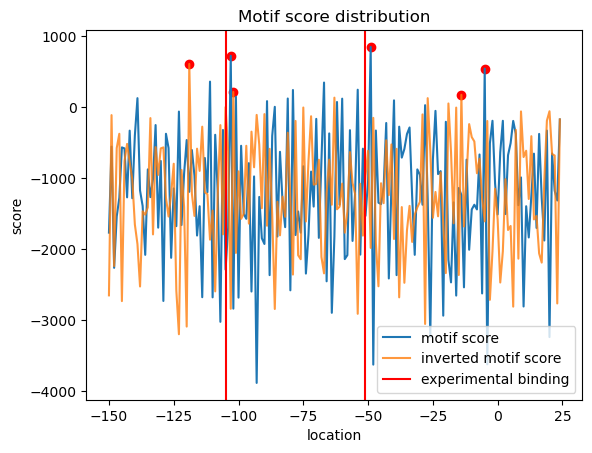

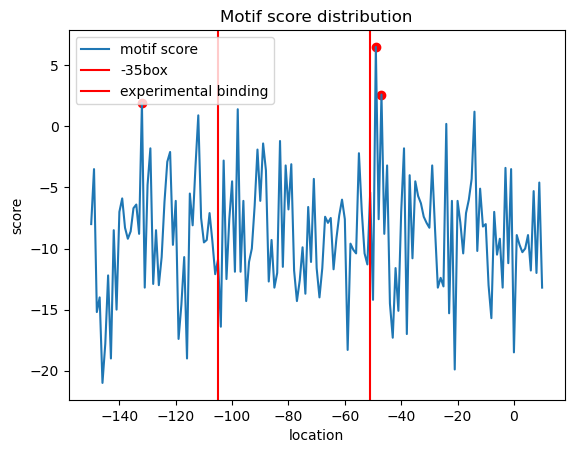

In [13]:
fig1 = plot_distr(gene_ID=('b1101',), true_sites=[-105,-51], split_motif=True, best_n=3, the_n_promt=1, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b1101',), true_sites=[-105,-51], split_motif=False, best_n=3, the_n_promt=1, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b1101',), true_sites=[-105,-51], split_motif=False, best_n=3, the_n_promt=1, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b1101', true_sites=[-105,-51], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)




**Averaging regulon motif doesn't work**

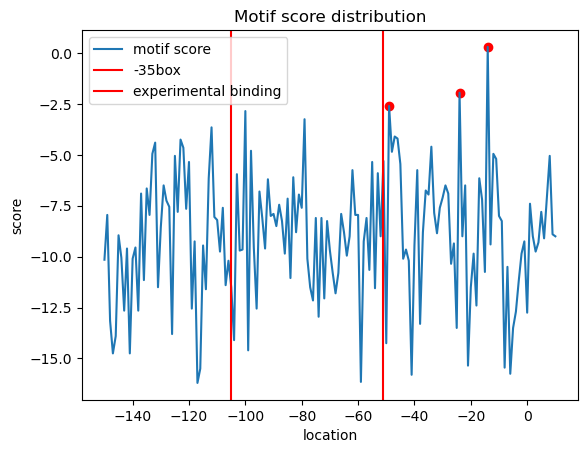

In [14]:
fig = plot_reg_distr(gene_ID='b1101', true_sites=[-105,-51], best_n=3, the_n_promt=0, distr_df=Crp2_features)

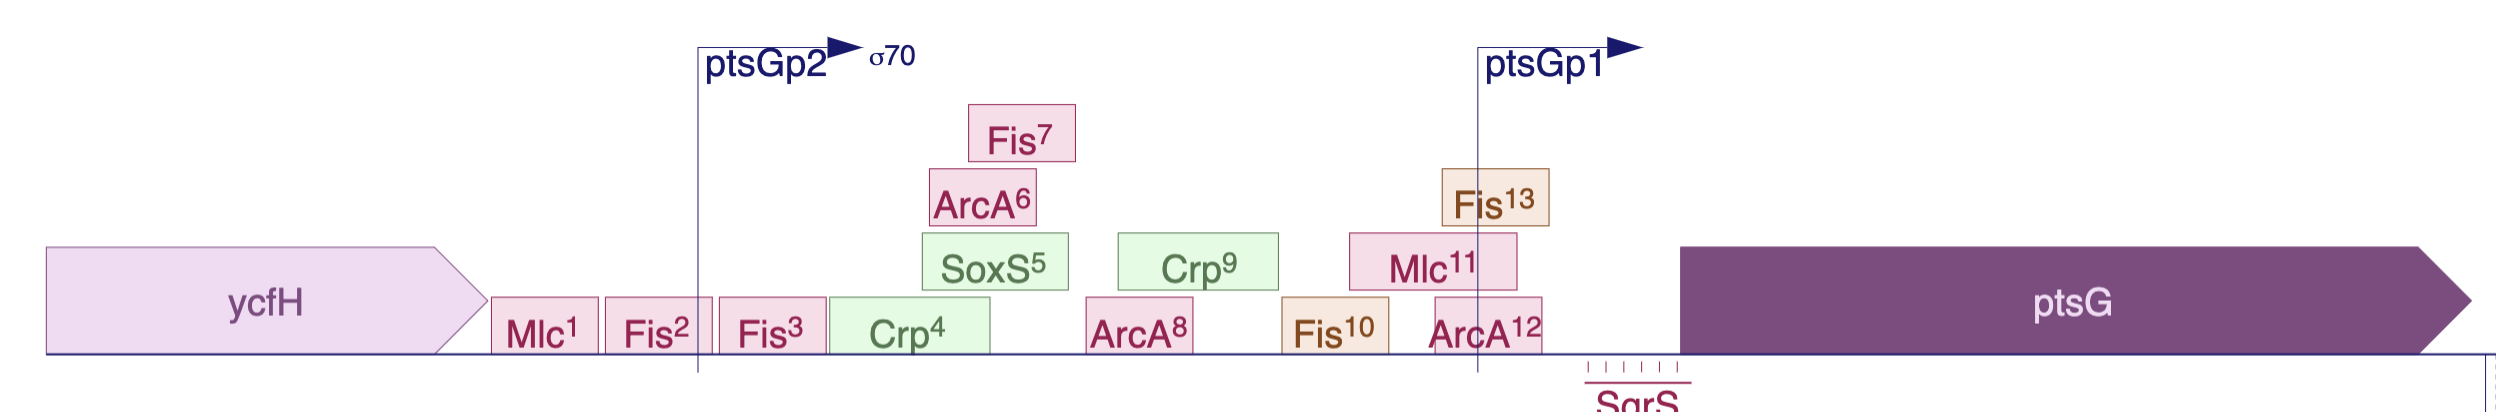

## sdhA (expression for both crp1 and crp2)
    - IM motif workd for both pal/no pal but regulon motif works better

**split pal**

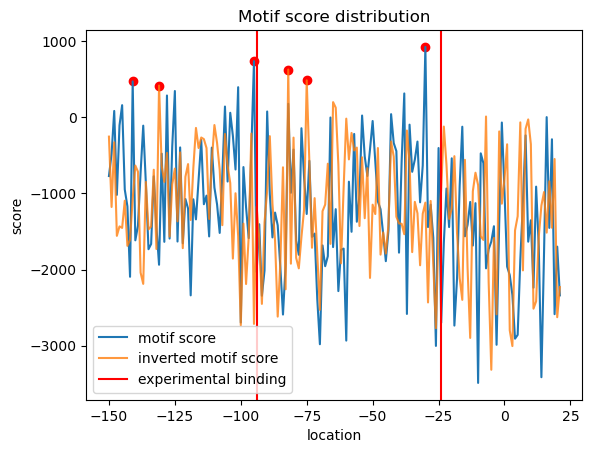

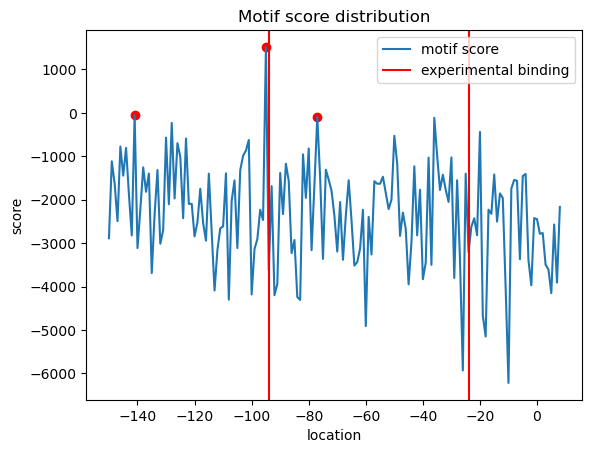

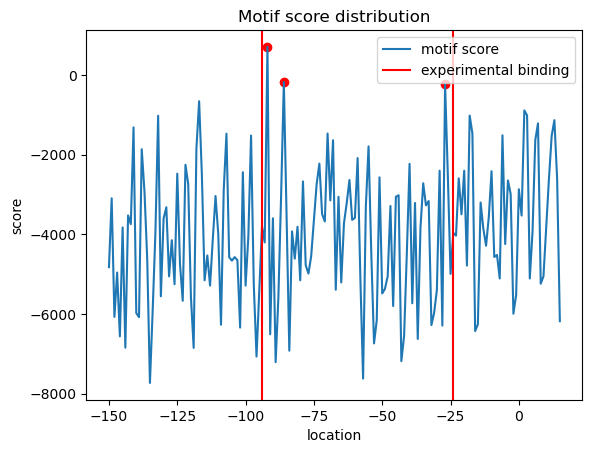

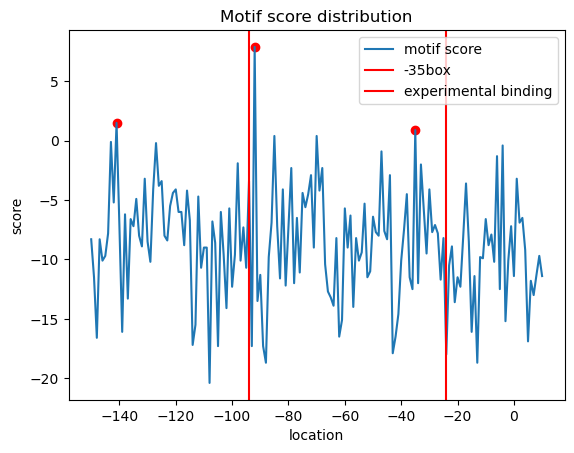

In [15]:
fig1 = plot_distr(gene_ID=('b0723',), true_sites=[-94,-24], split_motif=True, best_n=3, the_n_promt=0, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b0723',), true_sites=[-94,-24], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b0723',), true_sites=[-94,-24], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b0723', true_sites=[-94,-24], best_n=3, the_n_promt=1, distr_df=Crp2_features_large)




averaging regulon motif

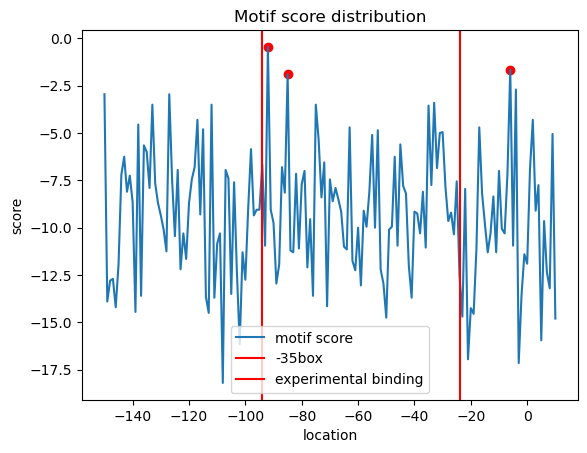

In [16]:
fig4 = plot_reg_distr(gene_ID='b0723', true_sites=[-94,-24], best_n=3, the_n_promt=0, distr_df=Crp2_features)


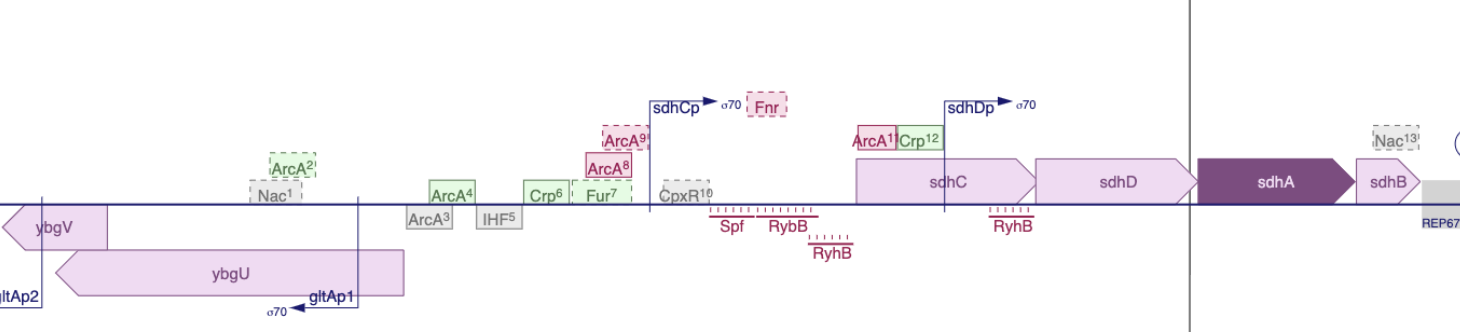

## gatA, B, D, Z, (Y)

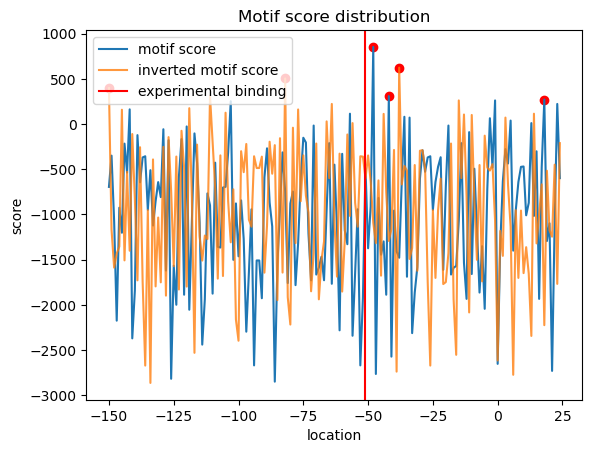

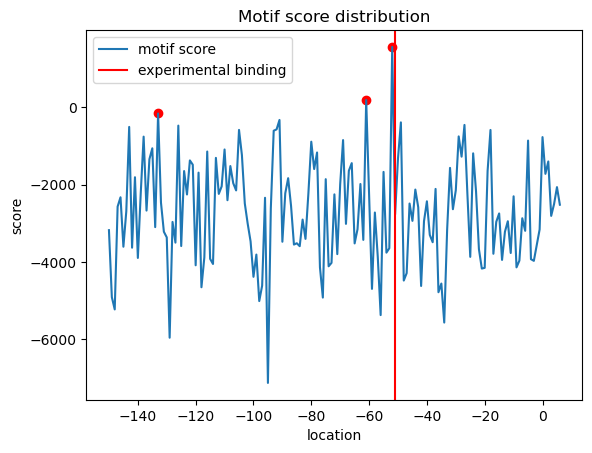

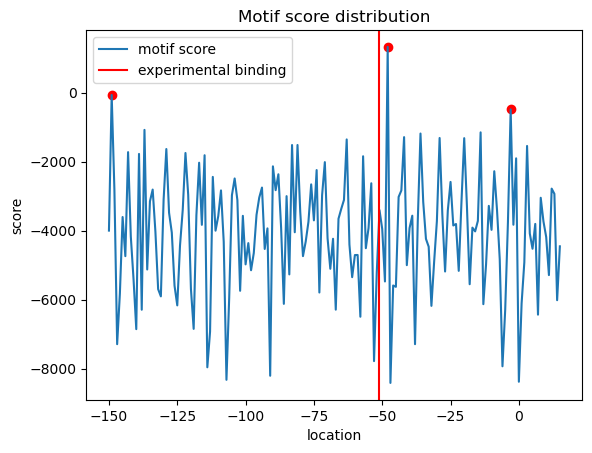

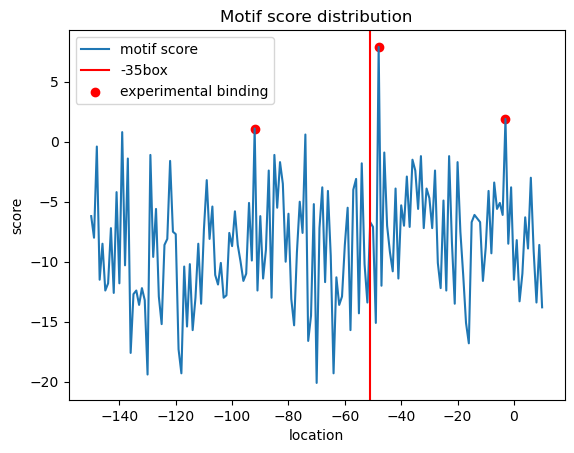

In [17]:
fig1 = plot_distr(gene_ID=('b2091', 'b2093', 'b2094', 'b2095', 'b2096'), true_sites=[-51], split_motif=True, best_n=3, the_n_promt=1, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b2091', 'b2093', 'b2094', 'b2095', 'b2096'), true_sites=[-51], split_motif=False, best_n=3, the_n_promt=1, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b2091', 'b2093', 'b2094', 'b2095', 'b2096'), true_sites=[-51], split_motif=False, best_n=3, the_n_promt=1, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b2091', true_sites=[-51], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)



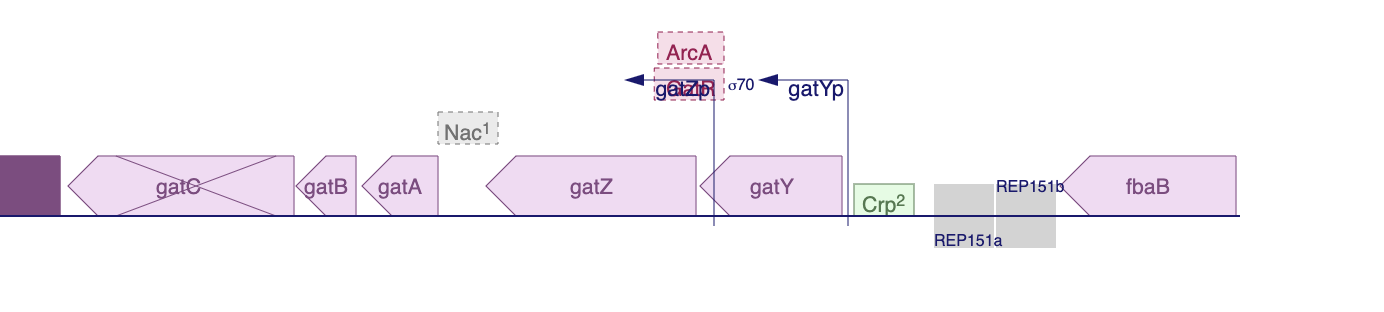

## mglA

  This one somehow works with averaging.
  pal works better than no pal

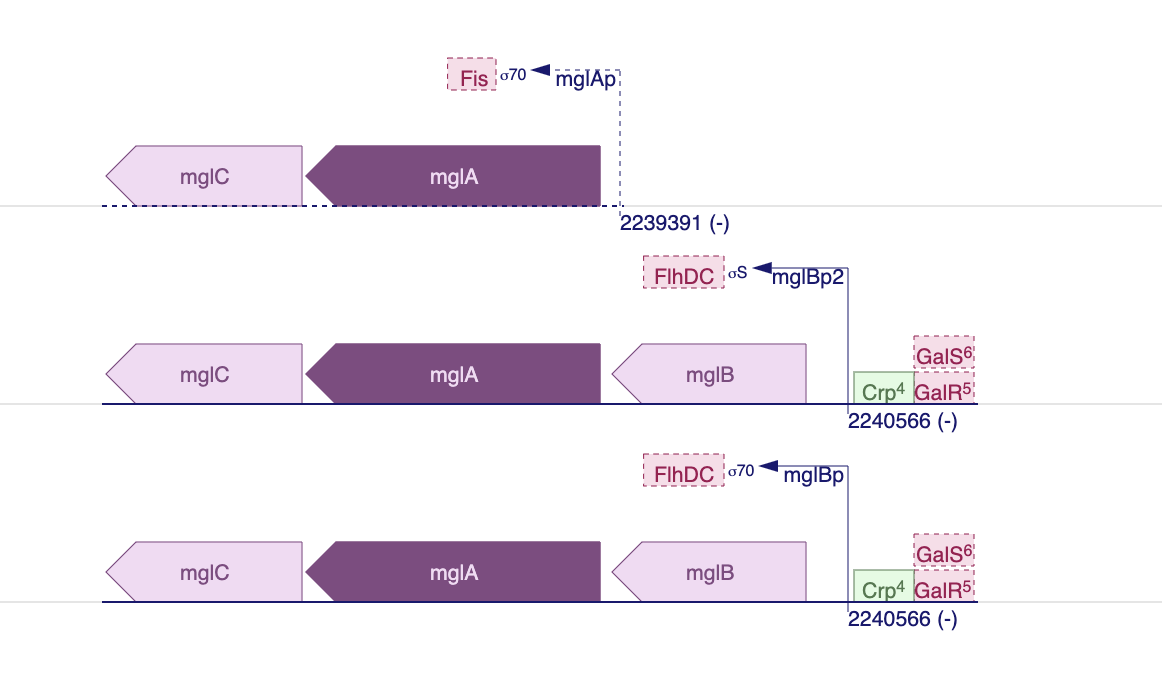

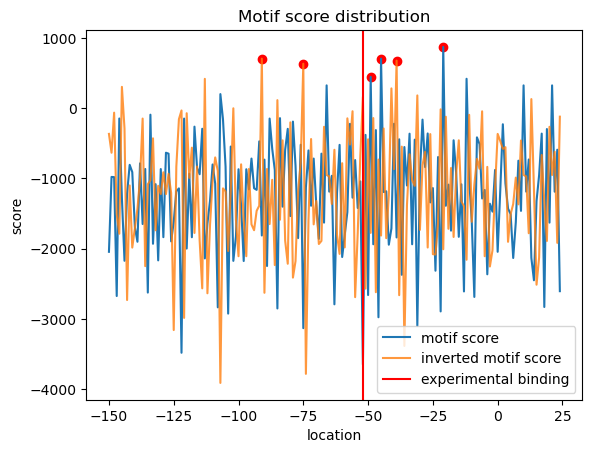

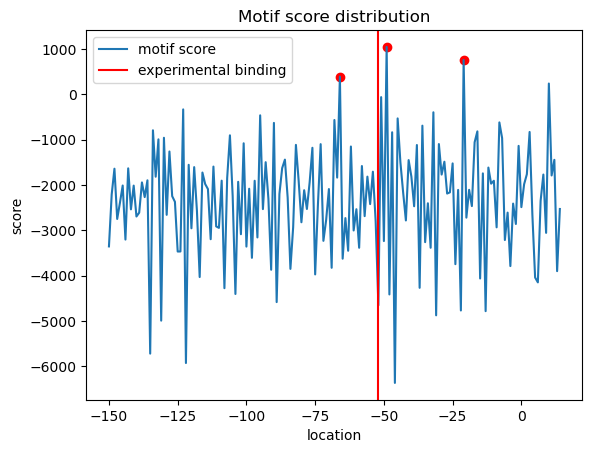

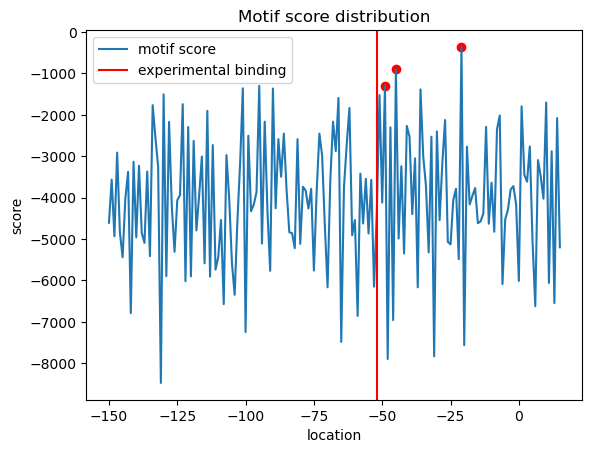

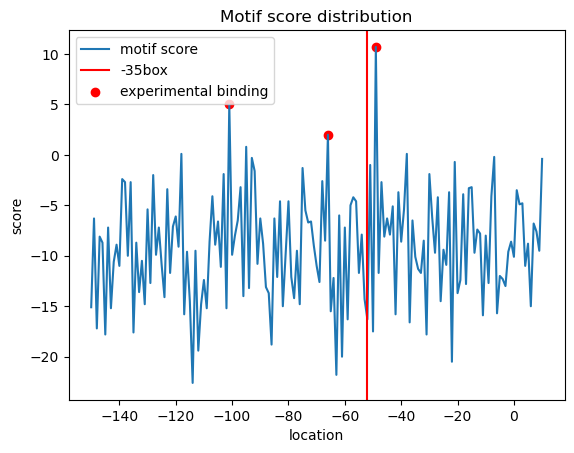

In [18]:
fig1 = plot_distr(gene_ID=('b2148', 'b2149', 'b2150'), true_sites=[-52], split_motif=True, best_n=3, the_n_promt=1, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b2148', 'b2149', 'b2150'), true_sites=[-52], split_motif=False, best_n=3, the_n_promt=1, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b2148', 'b2149', 'b2150'), true_sites=[-52], split_motif=False, best_n=3, the_n_promt=1, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b2148', true_sites=[-52], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)



## Others

## raiA

**split pal**

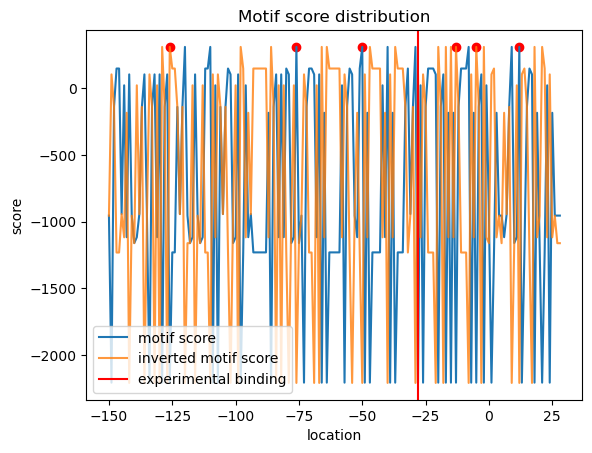

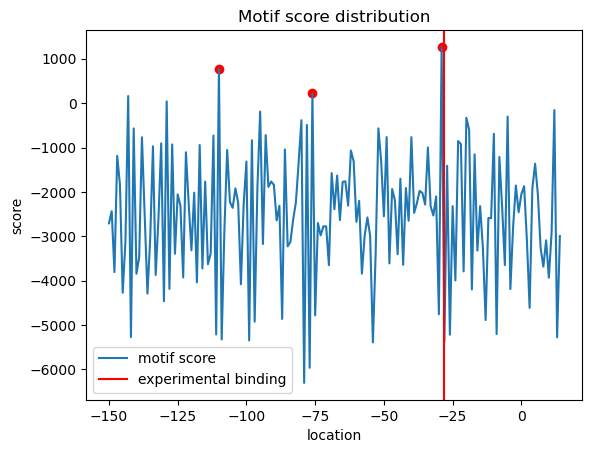

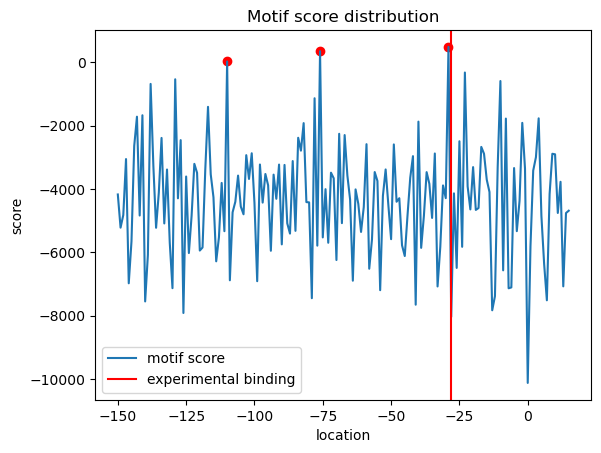

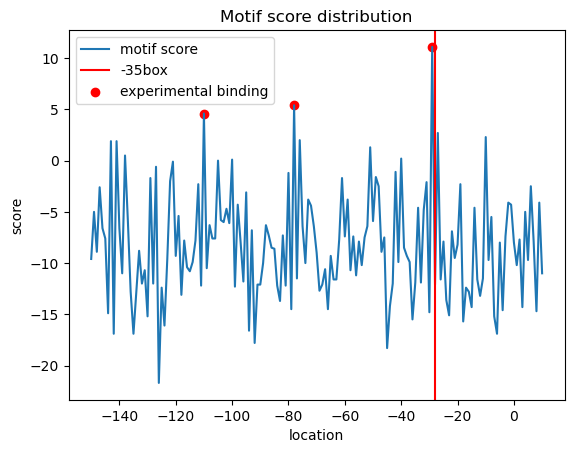

In [19]:
fig1 = plot_distr(gene_ID=('b2597',), true_sites=[-28], split_motif=True, best_n=3, the_n_promt=0, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b2597',), true_sites=[-28], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b2597',), true_sites=[-28], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b2597', true_sites=[-28], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)



Text(0, 0.5, 'score')

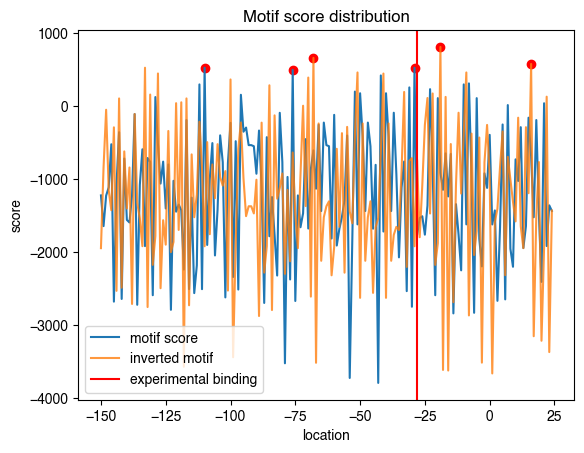

In [225]:
fig, ax = plt.subplots()
scores = np.array(val_scores_split[('b2597', )]['D'][0])
scores_inverted = np.array(val_scores_split[('b2597', )]['I'][0])
x=np.tile(np.arange(len(scores)), 1)- 150

scores_a = scores
ind = np.argpartition(scores_a, -n)[-n:]
ind_inverted = np.argpartition(scores_inverted, -n)[-n:]

ax.plot(x, scores_a)
ax.plot(x, scores_inverted, alpha= 0.8)
#ax.axvline(int(features[features['ID'] == 'b1101']['Sigma70_m35_Start']), color='orange')
ax.axvline(-28, color='r')
ax.scatter(x=x[ind], y=scores_a[ind], color='r')
ax.scatter(x=x[ind_inverted], y=scores_inverted[ind_inverted], color='r')

ax.legend(['motif score', 'inverted motif', 'experimental binding'])

ax.set_title('Motif score distribution');
ax.set_xlabel('location')
ax.set_ylabel('score')

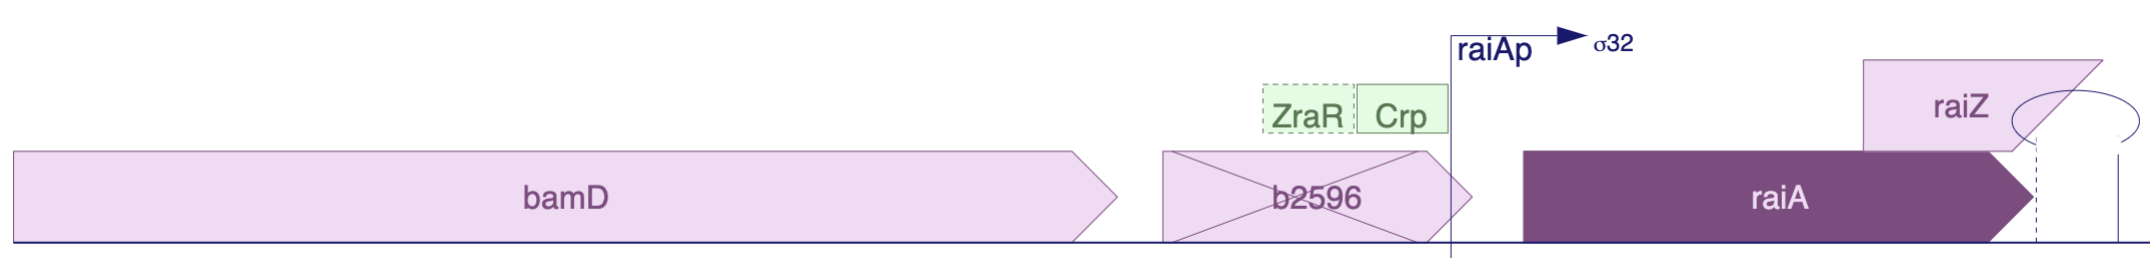

## manX, Y, Z (bad case)

IM motif doesn't work

**split pal**

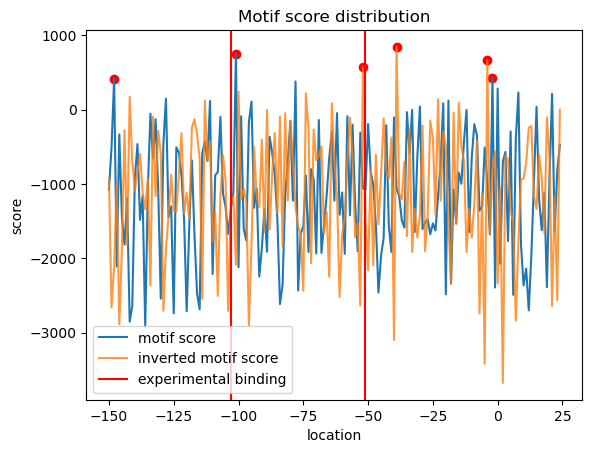

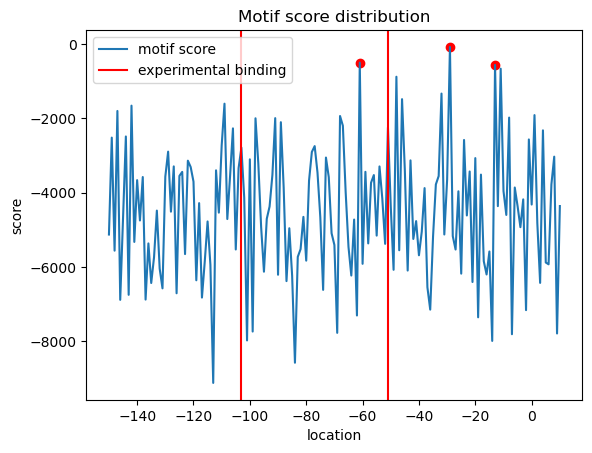

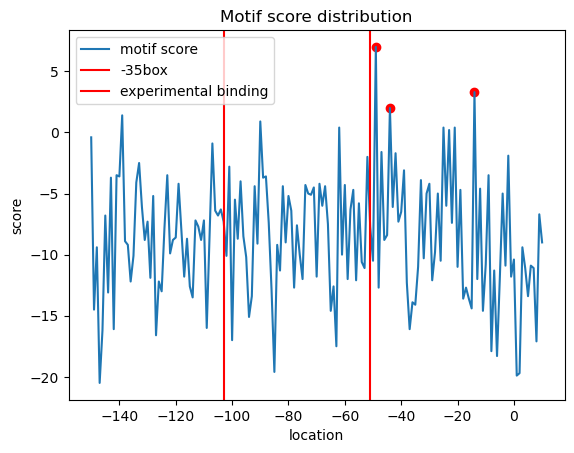

In [20]:
fig1 = plot_distr(gene_ID=('b1817', 'b1818', 'b1819'), true_sites=[-51, -103], split_motif=True, best_n=3, the_n_promt=0, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b1817', 'b1818', 'b1819'), true_sites=[-51, -103], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b1817', 'b1818', 'b1819'), true_sites=[-51, -103], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b1817', true_sites=[-51, -103], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)



Text(0, 0.5, 'score')

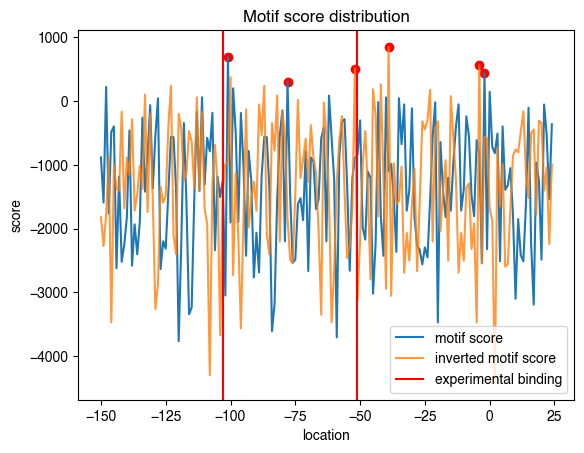

In [206]:
fig, ax = plt.subplots()
scores = np.array(val_scores_split[('b1817', 'b1818', 'b1819')]['D'][0])
scores_inverted = np.array(val_scores_split[('b1817', 'b1818', 'b1819')]['I'][0])
x=np.tile(np.arange(len(scores)), 1)- 150

scores_a = scores
ind = np.argpartition(scores_a, -n)[-n:]
ind_inverted = np.argpartition(scores_inverted, -n)[-n:]

ax.plot(x, scores_a)
ax.plot(x, scores_inverted, alpha= 0.8)
#ax.axvline(int(features[features['ID'] == 'b1101']['Sigma70_m35_Start']), color='orange')
ax.axvline(-51, color='r')
ax.axvline(-103, color='r')
ax.scatter(x=x[ind], y=scores_a[ind], color='r')
ax.scatter(x=x[ind_inverted], y=scores_inverted[ind_inverted], color='r')

ax.legend(['motif score', 'inverted motif score', 'experimental binding'])

ax.set_title('Motif score distribution');
ax.set_xlabel('location')
ax.set_ylabel('score')

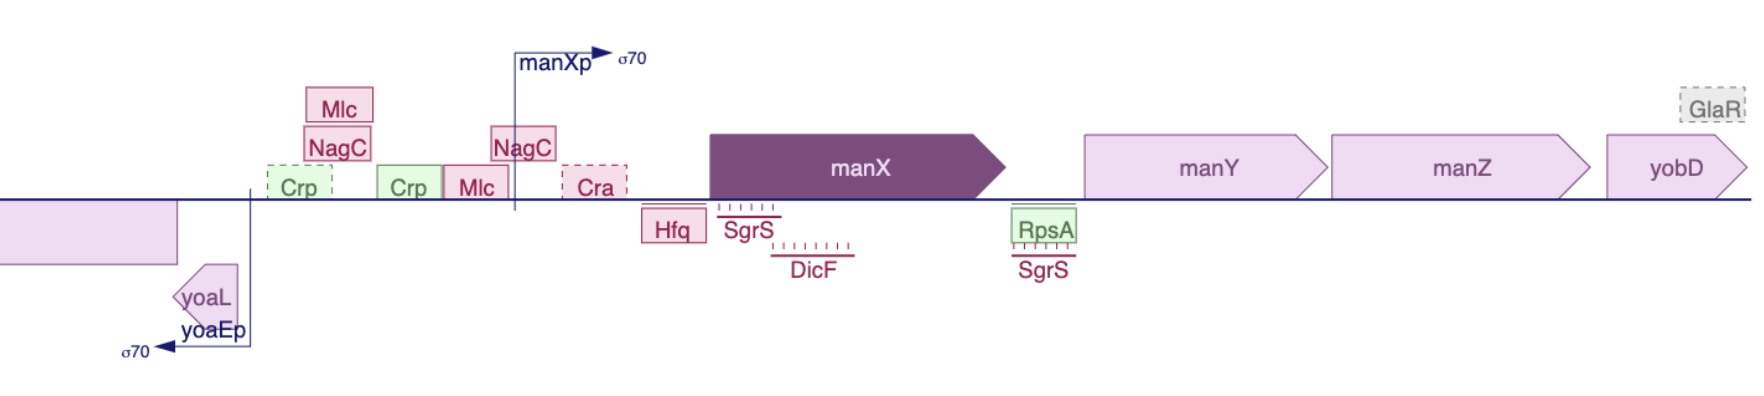

## mtlA, D, R (week regulation, low weighted)

**split pal**

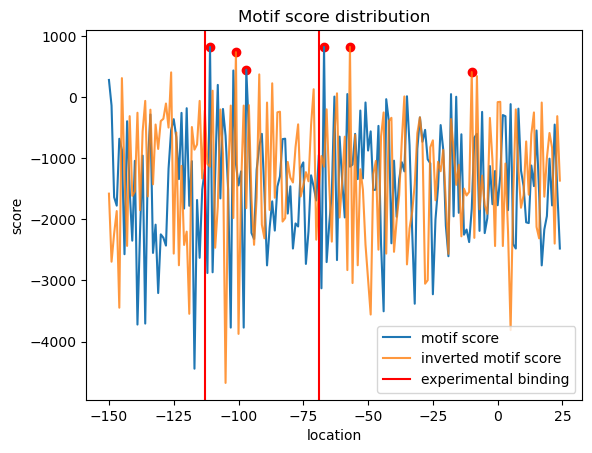

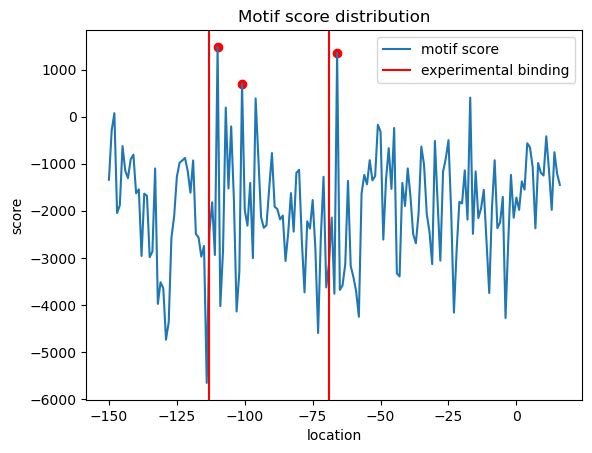

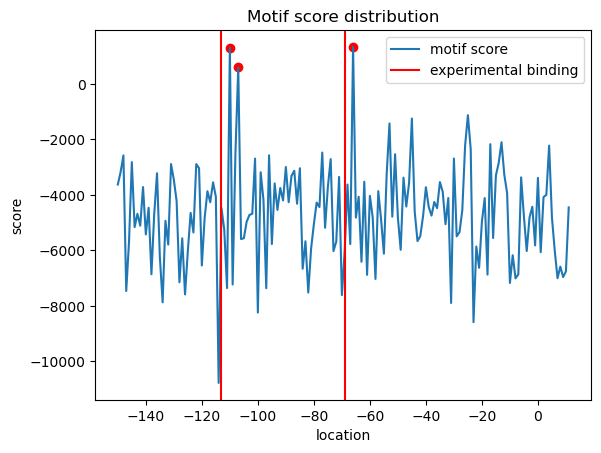

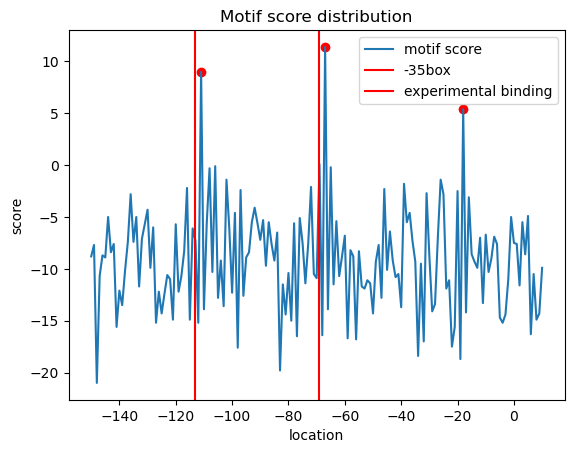

In [21]:
fig1 = plot_distr(gene_ID=('b3599', 'b3600', 'b3601'), true_sites=[-69, -113], split_motif=True, best_n=3, the_n_promt=0, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b3599', 'b3600', 'b3601'), true_sites=[-69, -113], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b3599', 'b3600', 'b3601'), true_sites=[-69, -113], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b3599', true_sites=[-69, -113], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)



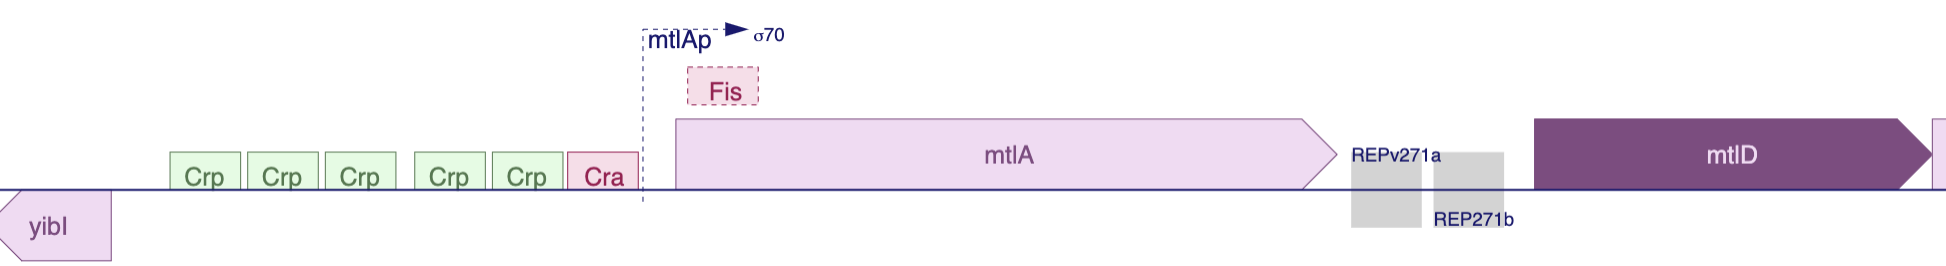

## aldA

**split pal**

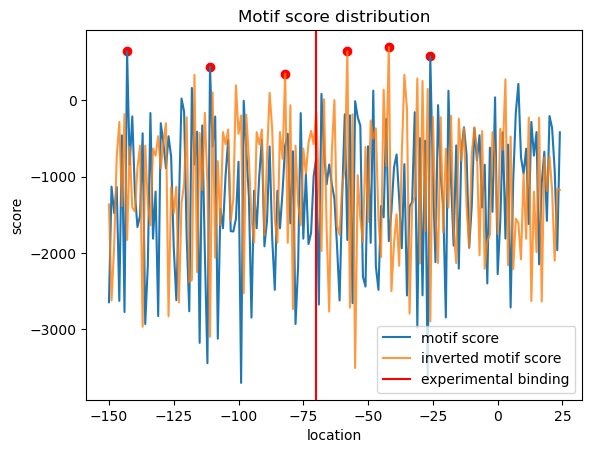

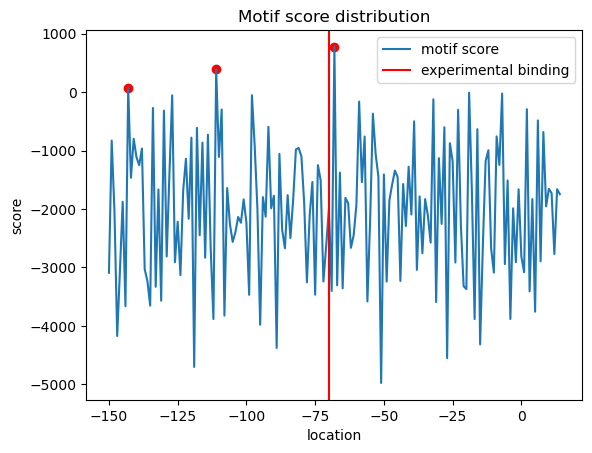

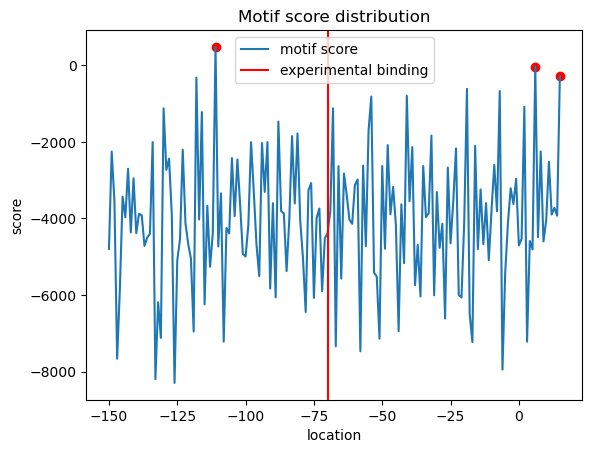

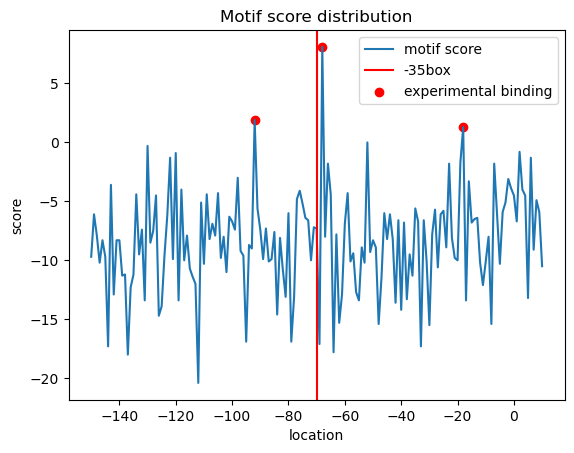

In [22]:
fig1 = plot_distr(gene_ID=('b1415',), true_sites=[-70], split_motif=True, best_n=3, the_n_promt=0, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b1415',), true_sites=[-70], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b1415',), true_sites=[-70], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b1415', true_sites=[-70], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)



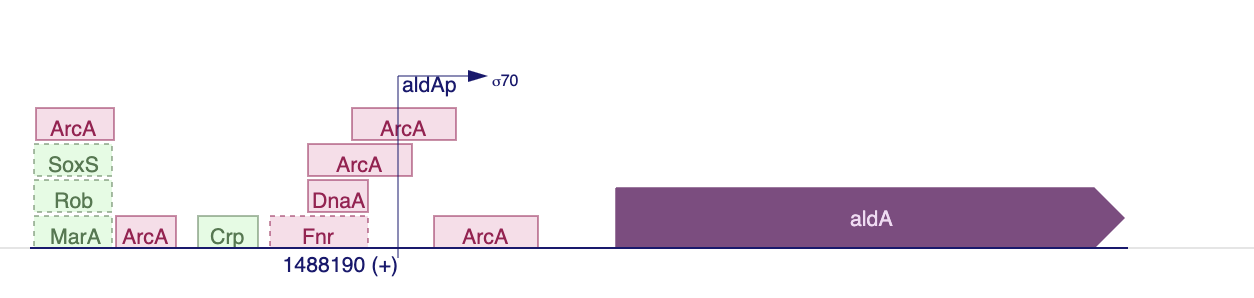
https://ecocyc.org/ECOLI/NEW-IMAGE?type=MAPTICK&object=1488000/1489671&chromosome=COLI-K12&bp-range=1488000/1489671

## pcK
**split pal**

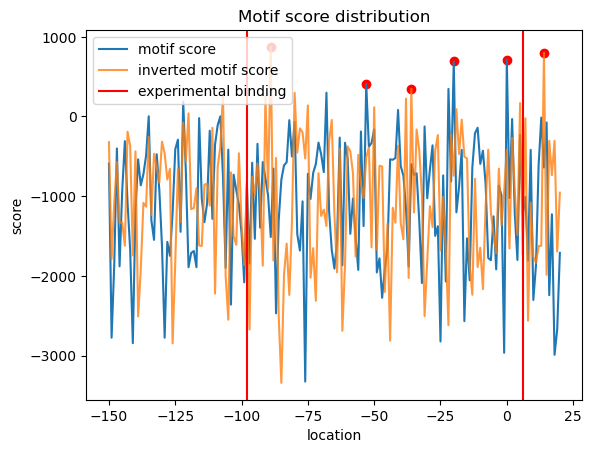

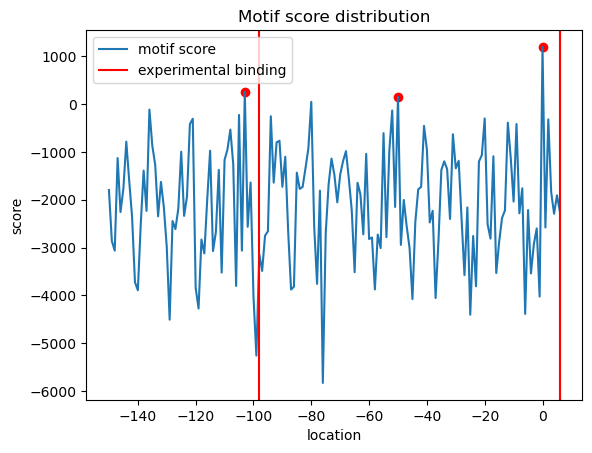

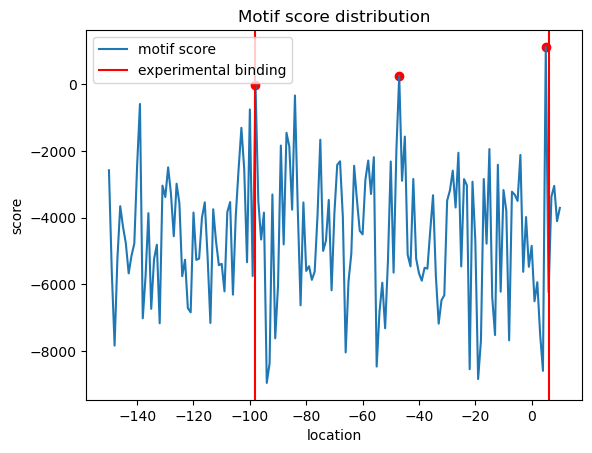

In [23]:
fig1 = plot_distr(gene_ID=('b3403',), true_sites=[-98,6], split_motif=True, best_n=3, the_n_promt=0, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b3403',), true_sites=[-98,6], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b3403',), true_sites=[-98,6], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b3403', true_sites=[-98,6], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)



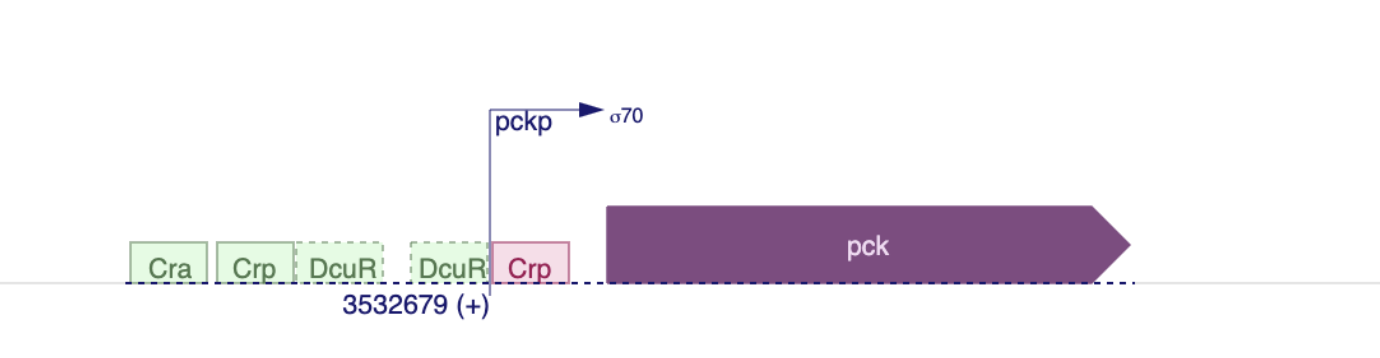

## glpQ, T

This gene is in multiple TU but only glpTQp is included in the calculated matrix.

**split pal**

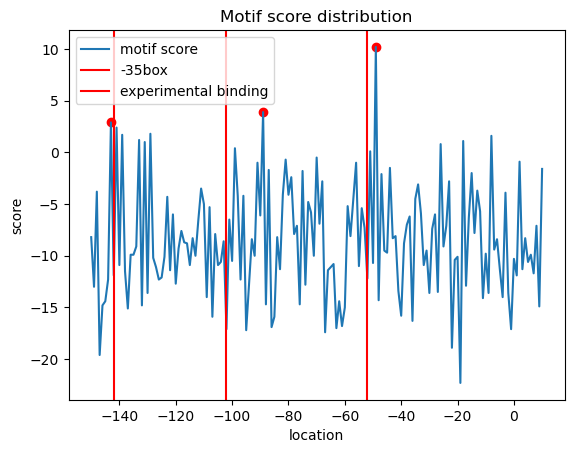

In [24]:
fig1 = plot_distr(gene_ID=('b2239', 'b2240'), true_sites=[-52, -102, -142], split_motif=True, best_n=3, the_n_promt=0, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b2239', 'b2240'), true_sites=[-52, -102, -142], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b2239', 'b2240'), true_sites=[-52, -102, -142], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b2239', true_sites=[-52, -102, -142], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)



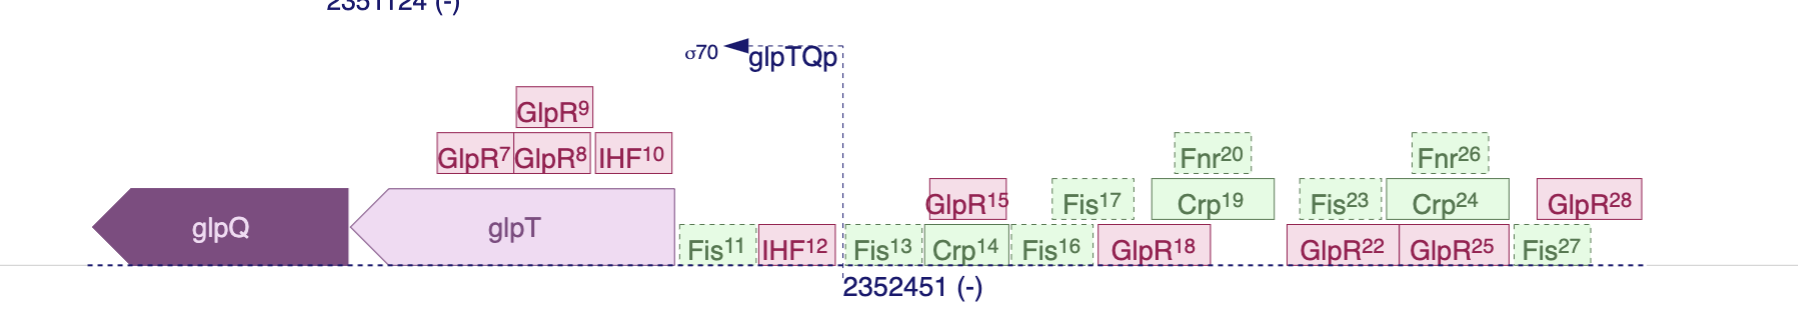

## galS
**split pal**

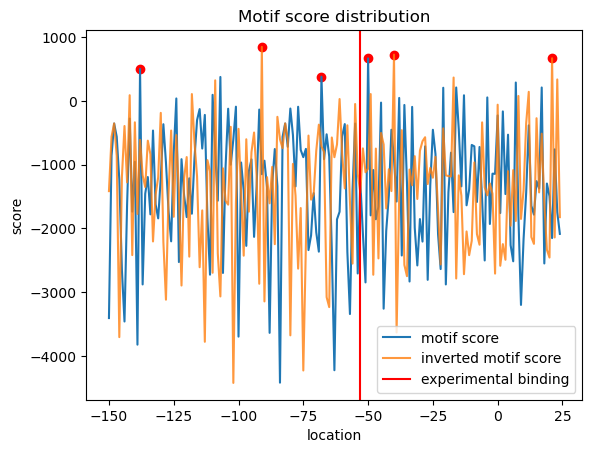

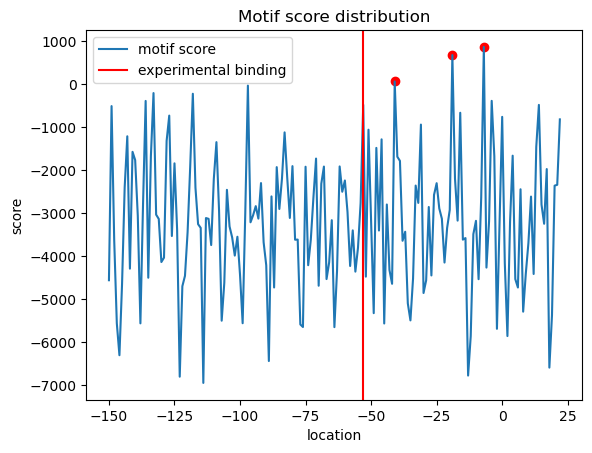

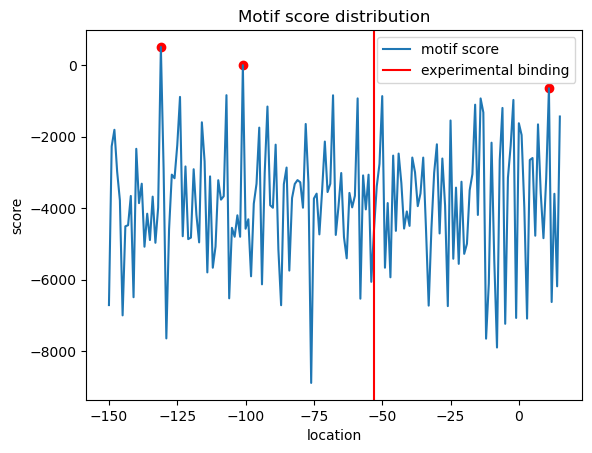

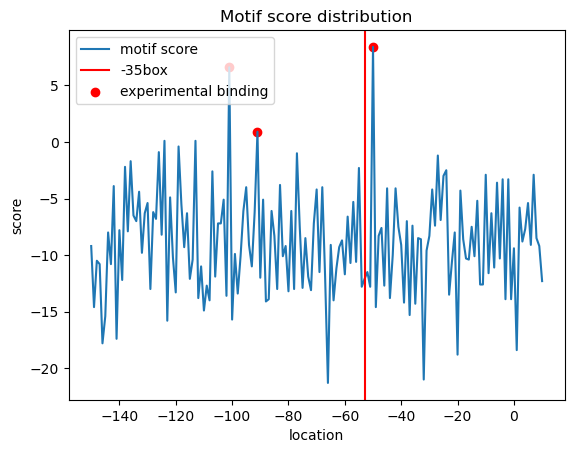

In [25]:
fig1 = plot_distr(gene_ID=('b2151',), true_sites=[-53], split_motif=True, best_n=3, the_n_promt=0, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b2151',), true_sites=[-53], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b2151',), true_sites=[-53], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b2151', true_sites=[-53], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)



## idnD

**no pal**

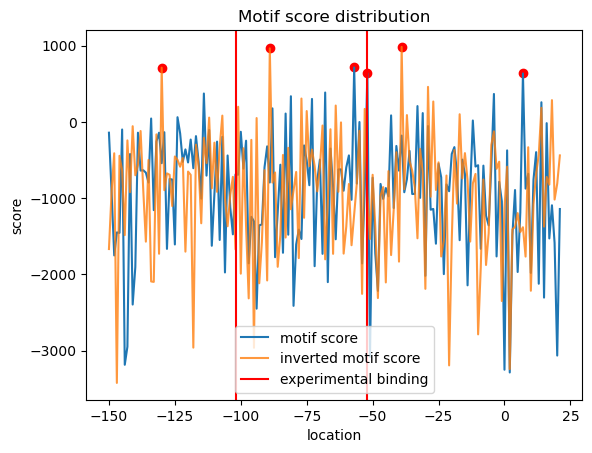

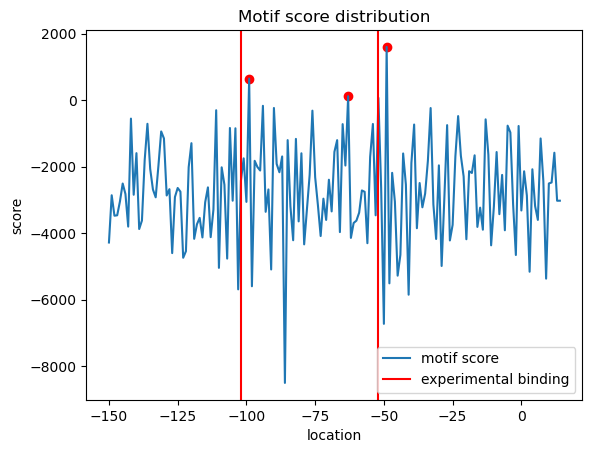

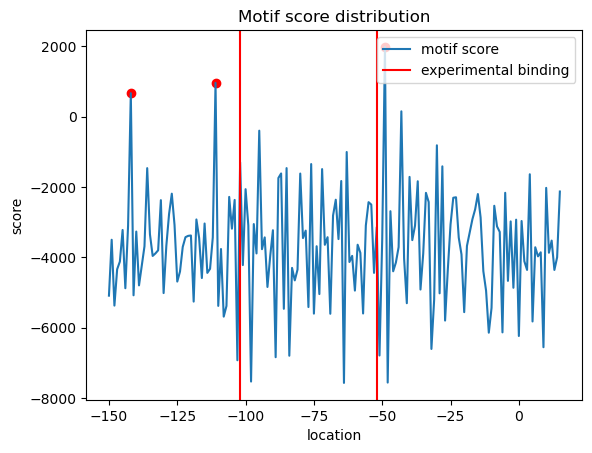

In [26]:
fig1 = plot_distr(gene_ID=('b4267',), true_sites=[-52,-102], split_motif=True, best_n=3, the_n_promt=0, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b4267',), true_sites=[-52,-102], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b4267',), true_sites=[-52,-102], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b4267', true_sites=[-52,-102], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)



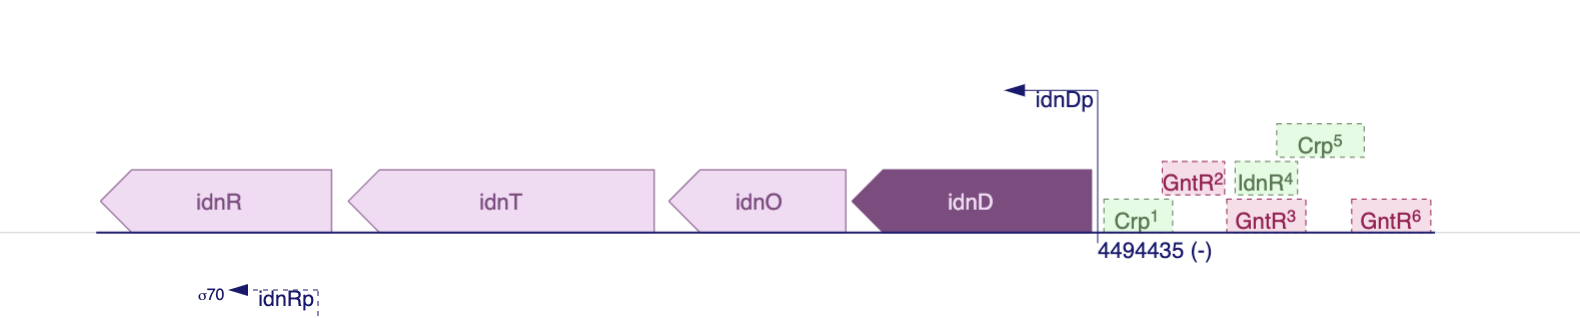

## cdd

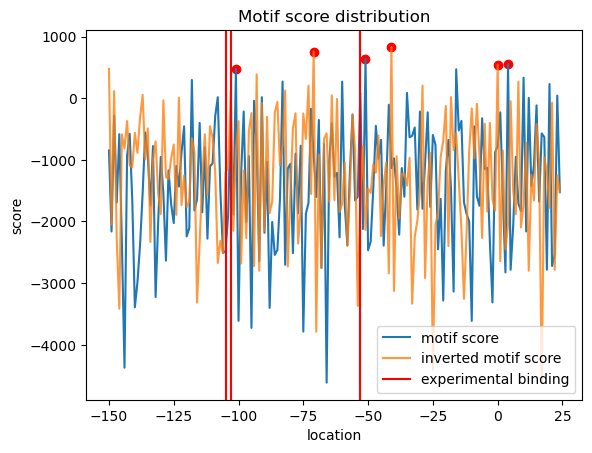

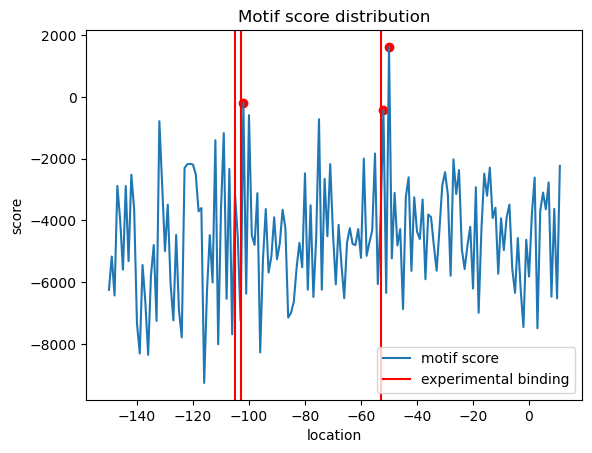

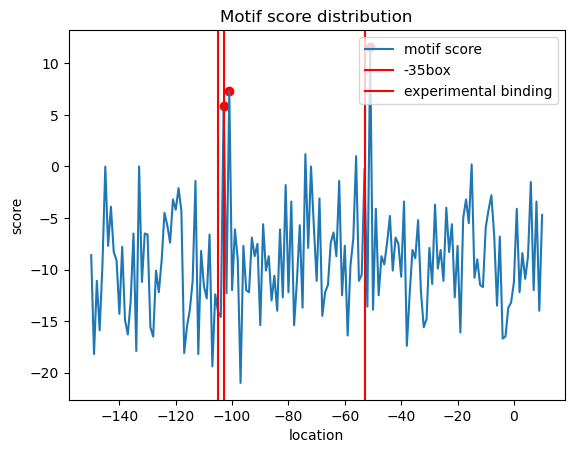

In [27]:
fig1 = plot_distr(gene_ID=('b2143',), true_sites=[-53,-103, -105], split_motif=True, best_n=3, the_n_promt=0, val_scores=val_scores_split)

fig2= plot_distr(gene_ID=('b2143',), true_sites=[-53,-103, -105], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores_pal)


fig3 = plot_distr(gene_ID=('b2143',), true_sites=[-53,-103, -105], split_motif=False, best_n=3, the_n_promt=0, val_scores=val_scores)

fig4 = plot_reg_distr(gene_ID='b2143', true_sites=[-53,-103, -105], best_n=3, the_n_promt=0, distr_df=Crp2_features_large)



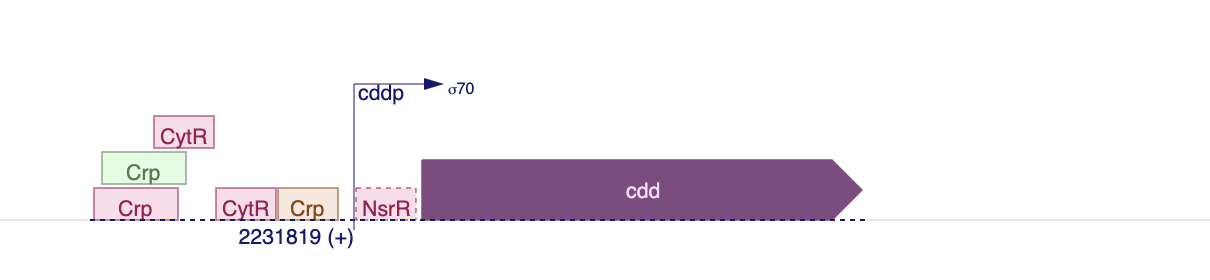